# Bottom-Up Hierarchical Clustering

An alternative approach to clustering is to “grow” clusters from the bottom up. We can do this in the following way:

1. Make each input its own cluster of one.
2. As long as there are multiple clusters remaining, find the two closest clusters and merge them.

At the end, we’ll have one giant cluster containing all the inputs. If we keep track of the merge order, we can recreate any number of clusters by unmerging. For example, if we want three clusters, we can just undo the last two merges.

In [33]:
from typing import NamedTuple, Union
from scratch.linear_algebra import Vector, List

class Leaf(NamedTuple):
    value: Vector

In [34]:
class Merged(NamedTuple):
    children: tuple
    order: int

In [38]:
leaf1 = ([10, 20],) # to make a 1-tuple you need the trailing comma
leaf2 = ([30, -15],) # otherwise Python treats the parentheses as parentheses

merged = (1, [leaf1, leaf2])

def is_leaf(cluster):
    """
    a cluster is a leaf if it has length 1
    """ 
    return len(cluster) == 1

def get_children(cluster):
    """
    returns the two children of this cluster if it's a merged cluster; 
    raises an exception if this is a leaf cluster
    """
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children") 
    else:
        return cluster[1]

def get_values(cluster):
    """
    returns the value in this cluster (if it's a leaf cluster) 
    or all the values in the leaf clusters below it (if it's not)
    """ 
    if is_leaf(cluster):
        return cluster # is already a 1-tuple containing value else:
    return [value for child in get_children(cluster) for value in get_values(child)]

In [37]:
assert get_values(merged) == [[10, 20], [30, -15]]
get_values(merged)

[[10, 20], [30, -15]]

In order to merge the closest clusters, `we need some notion of the distance between clusters`. We’ll use the `minimum distance` between elements of the two clusters, which merges the two clusters that are closest to touching (but will sometimes produce large chain-like clusters that aren’t very tight). If we wanted tight spherical clusters, we might use the `maximum distance` instead, as it merges the two clusters that fit in the smallest ball. Both are common choices, as is the `average distance`:

In [39]:
def cluster_distance(cluster1, cluster2, distance_agg=min):
    """
    compute all the pairwise distances between cluster1 and cluster2 
    and apply _distance_agg_ to the resulting list
    """
    return distance_agg([distance(input1, input2) 
                         for input1 in get_values(cluster1) 
                         for input2 in get_values(cluster2)])

We’ll use the `merge order slot` to track the order in which we did the merging. Smaller numbers will represent later merges. This means when we want to unmerge clusters, we do so from lowest merge order to highest. Since leaf clusters were never merged (which means we never want to unmerge them), we’ll assign them infinity:

In [40]:
def get_merge_order(cluster): 
    if is_leaf(cluster):
        return float('inf') 
    else:
        return cluster[0] # merge_order is first element of 2-tuple

In [45]:
def bottom_up_cluster(inputs, distance_agg=min):
    
    # start with every input a leaf cluster / 1-tuple clusters = [(input,) for input in inputs]
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        
        # find the two closest clusters 
        c1, c2 = min([(cluster1, cluster2) 
                      for i, cluster1 in enumerate(clusters) 
                      for cluster2 in clusters[:i]], 
                     key=lambda (x, y): cluster_distance(x, y, distance_agg))
            
        # remove them from the list of clusters
        clusters=[cforcinclustersifc!=c1andc!=c2] 
        
        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2]) 
        
        # and add their merge
        clusters.append(merged_cluster)
        
    # when there's only one cluster left, return it
    return clusters[0]

SyntaxError: invalid syntax (<ipython-input-45-281f96509c08>, line 11)

In [ ]:
base_cluster = bottom_up_cluster(inputs)

In [70]:
from typing import NamedTuple, Union

class Leaf(NamedTuple):
    value: Vector

leaf1 = Leaf([10,  20])
leaf2 = Leaf([30, -15])

class Merged(NamedTuple):
    children: tuple
    order: int

merged = Merged((leaf1, leaf2), order=1)

Cluster = Union[Leaf, Merged]

def get_values(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]

assert get_values(merged) == [[10, 20], [30, -15]]

from typing import Callable
from scratch.linear_algebra import distance

def cluster_distance(cluster1: Cluster,
                     cluster2: Cluster,
                     distance_agg: Callable = min) -> float:
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting list
    """
    return distance_agg([distance(v1, v2)
                         for v1 in get_values(cluster1)
                         for v2 in get_values(cluster2)])

def get_merge_order(cluster: Cluster) -> float:
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order

from typing import Tuple

def get_children(cluster: Cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children

def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min) -> Cluster:
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair: Tuple[Cluster, Cluster]) -> float:
        return cluster_distance(pair[0], pair[1], distance_agg)

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2)
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

def generate_clusters(base_cluster: Cluster,
                      num_clusters: int) -> List[Cluster]:
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [71]:
# Small number of points for learning how algorythm works
inputs1: List[List[float]] = [[-14,-5],
                             [-13,-6],
                             [5,6], [7,8]]

In [72]:
base_cluster = bottom_up_cluster(inputs1)
base_cluster

Merged(children=(Merged(children=(Leaf(value=[7, 8]), Leaf(value=[5, 6])), order=1), Merged(children=(Leaf(value=[-13, -6]), Leaf(value=[-14, -5])), order=2)), order=0)

In [73]:
three_clusters = [get_values(cluster) 
                  for cluster in generate_clusters(base_cluster, 3)]

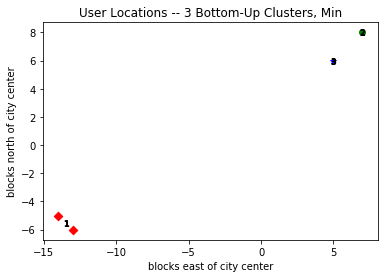

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
from scratch.linear_algebra import vector_mean

for i, cluster, marker, color in zip([1, 2, 3],
                                     three_clusters,
                                     ['D','o','*'],
                                     ['r','g','b']):
    xs, ys = zip(*cluster)  # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker=marker)

    # put a number at the mean of the cluster
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title("User Locations -- 3 Bottom-Up Clusters, Min")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.savefig('images/clustering4.png')
plt.show()

In [75]:
inputs2: List[List[float]] = [[-14,-5],[13,13],[20,23],
                             [-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],
                             [-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],
                             [-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]
    
base_cluster = bottom_up_cluster(inputs2)
three_clusters = [get_values(cluster) 
                  for cluster in generate_clusters(base_cluster, 3)]

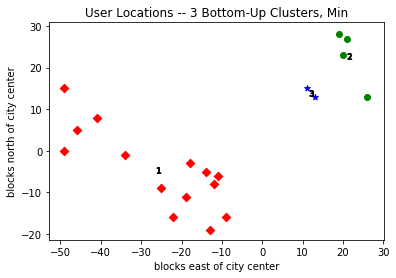

In [76]:
for i, cluster, marker, color in zip([1, 2, 3],
                                     three_clusters,
                                     ['D','o','*'],
                                     ['r','g','b']):
    xs, ys = zip(*cluster)  # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker=marker)

    # put a number at the mean of the cluster
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title("User Locations -- 3 Bottom-Up Clusters, Min")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.savefig('images/clustering4.png')
plt.show()

This gives very different results than k-means did. This is because using `min` in `cluster_distance` tends to give chain-like clusters. If we instead use `max` (which gives tight clusters) it looks the same as the 3-means result:

In [78]:
base_cluster = bottom_up_cluster(inputs2, max)
three_clusters = [get_values(cluster) 
                  for cluster in generate_clusters(base_cluster, 3)]

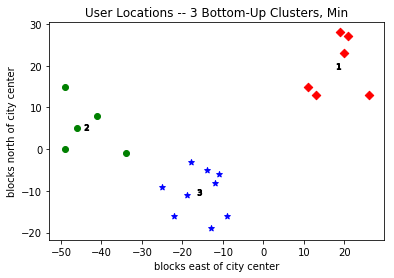

In [79]:
for i, cluster, marker, color in zip([1, 2, 3],
                                     three_clusters,
                                     ['D','o','*'],
                                     ['r','g','b']):
    xs, ys = zip(*cluster)  # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker=marker)

    # put a number at the mean of the cluster
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title("User Locations -- 3 Bottom-Up Clusters, Min")
plt.xlabel("blocks east of city center")
plt.ylabel("blocks north of city center")
plt.savefig('images/clustering5.png')
plt.show()